In [1]:
from math import *
import math
import numpy as np
from mpmath import *
mp.dps = 15; mp.pretty = True
import sys
from iapws import IAPWS97
from ipywidgets import interact, interactive, fixed, interact_manual,FloatSlider, FloatRangeSlider,VBox, HBox, Label,Dropdown, Checkbox
from ipywidgets import widgets
from IPython.display import display, Math, Latex
from scipy import interpolate

In [2]:
def interact_hookup(f, controls):
    from ipywidgets import Output
    from IPython.display import clear_output
    def observer(change):   
        clear_output()
        kwargs = {k:v.value for k,v in controls.items()}
        f(**kwargs)
    for k,w in controls.items():
        w.observe(observer, 'value')  
    observer(None)  

In [3]:
def dittus_boelter(Re,Pr):
    Nu = 0.023*(Re**0.8)*(Pr**0.4)
    return Nu

In [4]:
def reynolds_number(mdot,A,mu,D):
    Re = mdot*D/(A*mu)
    return Re

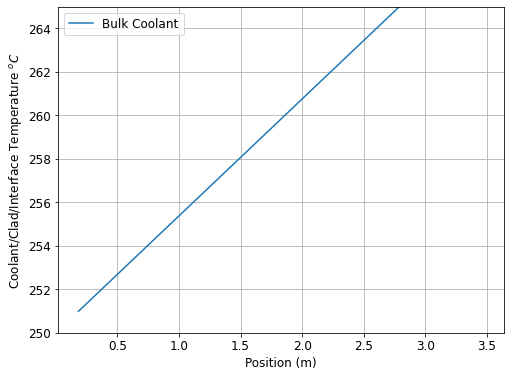

In [5]:
def calc(pressure,T_in,mdot,ylim,interp,Tb_cb,Tc_cb,Ts_cb,Tm_cb,qppp0,qppp1,qppp2,qppp3,qppp4,qppp5,qppp6,qppp7,qppp8,qppp9):
    # pressure is in MPa

    
    D_rod      = 0.0095
    pitch      = 0.0125
    c          = 0.0007
    r1         = (D_rod - 2.0*c)/2.0     # divide by 1000.0 because c and D_rod are in mm
    r2         = D_rod/2.0               # divide by 1000.0 because D_rod is in mm
    A_rod      = (np.pi*(D_rod)**2.0)/4.0
    A_flow     = pitch**2.0 - A_rod
    H          = 3.66
    q          = 60.0E3
    kc         = 10.0
    kf         = 3.0
    
    N_elements = 10
    
    # setup linearly spaced 1d mesh
    z_faces    = np.linspace(0.0,H,N_elements+1)        # 1d array defining the z-positions at which to calculate the temperatures
    l_element  = z_faces[1] - z_faces[0]  
    v_flow_element  = l_element*A_flow
    v_rod_element   = l_element*A_rod
    z_centres  = np.linspace(l_element/2.0,H-l_element/2.0,N_elements)    
    
    qppp_av         = q/(A_rod*np.sum(l_element))

    # setup array to hold the element volumetric powers and assign from user input
    qppp_centres= np.zeros_like(z_centres)
    qppp_centres[0] = qppp0
    qppp_centres[1] = qppp1
    qppp_centres[2] = qppp2
    qppp_centres[3] = qppp3
    qppp_centres[4] = qppp4
    qppp_centres[5] = qppp5
    qppp_centres[6] = qppp6
    qppp_centres[7] = qppp7
    qppp_centres[8] = qppp8
    qppp_centres[9] = qppp8

    # scale qppp so that total q is correct
    qppp_centres = qppp_av*qppp_centres/np.sum(qppp_centres)    
    
    # setup arrays to hold solution
    Tb_faces    = np.zeros_like(z_faces)
    Tb_centres  = np.zeros_like(z_centres)
    Tc_faces    = np.zeros_like(z_faces)
    Tc_centres  = np.zeros_like(z_centres)
    Ts_faces    = np.zeros_like(z_faces)
    Ts_centres  = np.zeros_like(z_centres)
    Tm_faces    = np.zeros_like(z_faces)
    Tm_centres  = np.zeros_like(z_centres)

    # saturation properties
    sat_vapour=IAPWS97(P=pressure,x=1)                
    sat_liquid=IAPWS97(P=pressure,x=0)              
    cp    = sat_liquid.cp*1000.0        # specific heat capacity (kJ/kgK)
    Pr    = sat_liquid.Prandt
    mu    = sat_liquid.mu
    k     = sat_liquid.k
    rho   = sat_liquid.rho

    # Calculate
    Tb_faces[0] = T_in
    for i in np.arange(Tb_faces.size):
        if (i > 0):
            Tb_faces[i] = Tb_faces[i-1]+qppp_centres[i-1]*v_rod_element/(mdot*cp)

    Tb_centres  = np.interp(z_centres,z_faces,Tb_faces)

    # Determine the convective heat transfer coefficient
    Dh = 4.0*A_flow/(np.pi*D_rod)
    Re = reynolds_number(mdot,A_flow,mu,Dh)
    Nu = dittus_boelter(Re,Pr)
    h  = Nu*k/Dh
    

    # calculate the coolant temperature at each z point                                
    Tc_centres = Tb_centres + qppp_centres*v_rod_element/(np.pi*D_rod*l_element*h)
    Ts_centres = Tc_centres + qppp_centres*A_rod*np.log(r2/r1)/(2.0*np.pi*kc)
    Tm_centres = Ts_centres + qppp_centres*A_rod/(4.0*np.pi*kf)
    
    # Perform cubic sline interpolation
    n_interp = 100
    z_interp = np.linspace(l_element/2.0,H-l_element/2.0,n_interp)
    
    if (interp):
        tck = interpolate.splrep(z_centres,Tb_centres, s=0)
        Tb_interp = interpolate.splev(z_interp, tck, der=0)
        tck = interpolate.splrep(z_centres,Tc_centres, s=0)
        Tc_interp = interpolate.splev(z_interp, tck, der=0)
        tck = interpolate.splrep(z_centres,Ts_centres, s=0)
        Ts_interp = interpolate.splev(z_interp, tck, der=0)
        tck = interpolate.splrep(z_centres,Tm_centres, s=0)
        Tm_interp = interpolate.splev(z_interp, tck, der=0)
    
    
    from matplotlib import pyplot as plt
#     %matplotlib inline
    
    plt.rcParams['font.size']=12
    fig_size = [0,0]
    fig_size[0] = 8
    fig_size[1] = 6
    plt.rcParams["figure.figsize"] = fig_size
    
    plt.figure()
    if (interp):
        if (Tb_cb):
            Tb_plot = plt.plot(z_interp,Tb_interp, label='Bulk Coolant')
        if (Tc_cb):
            Tc_plot = plt.plot(z_interp,Tc_interp, label='Clad Surface')
        if (Ts_cb):
            Ts_plot = plt.plot(z_interp,Ts_interp, label='Fuel/Clad Interface')
    else:    
        if (Tb_cb):
            Tb_plot = plt.plot(z_centres,Tb_centres, label='Bulk Coolant')
        if (Tc_cb):
            Tc_plot = plt.plot(z_centres,Tc_centres, label='Clad Surface')
        if (Ts_cb):
            Ts_plot = plt.plot(z_centres,Ts_centres, label='Fuel/Clad Interface')
    
    plt.xlabel('Position (m)')
    plt.ylabel('Coolant/Clad/Interface Temperature $^oC$')
    plt.ylim([ylim[0],ylim[1]])
    plt.grid(True)
    if (interp):
        if (Tm_cb):
            ax1 = plt.gca()
            ax2 = ax1.twinx()
            ax2.plot(z_interp, Tm_interp,'g--',label='Fuel Centre')
            ax2.set_ylabel('Fuel Centre Temperature')
    else:
        if (Tm_cb):
            ax1 = plt.gca()
            ax2 = ax1.twinx()
            ax2.plot(z_centres, Tm_centres,'g--',label='Fuel Centre')
            ax2.set_ylabel('Fuel Centre Temperature')
    plt.legend()
    plt.show()   
    display(UI)
    
#     display(Latex(r' '))
#     display(Latex(r'Hydraulic Diameter       : '+str(int(Dh*1000.0))+r' mm'))
#     display(Latex(r'Reynolds Number          : '+str(int(Re))))
#     display(Latex(r'Nusselt Number           : '+str(int(Nu))))
#     display(Latex(r'Heat transfer coefficient: '+str(int(h))+r' W/m$^2$K'))


w =dict( pressure=FloatSlider(description='P (MPa)',value=15.5,min=0.1, max=22.0, step=0.1, continuous_update=False),
         T_in=FloatSlider(description='T_in',value=250.0,min=200.0, max=300.0, step=0.1, continuous_update=False),
         mdot=FloatSlider(description='mdot',value=0.34,min=0.01, max=1.0, step=0.01, continuous_update=False),
         ylim=FloatRangeSlider(value=[250.0, 265.0],min=200.0,max=400.0,step=5.0,description='Y Limits',disabled=False,continuous_update=False,orientation='horizontal'),
         interp=Checkbox(value=False,description='Smooth',disabled=False),
         Tb_cb=Checkbox(value=True,description='Bulk Coolant',disabled=False),
         Tc_cb=Checkbox(value=False,description='Clad Surface',disabled=False),
         Ts_cb=Checkbox(value=False,description='Fuel/Clad Interface',disabled=False),
         Tm_cb=Checkbox(value=False,description='Fuel Centre',disabled=False),
         qppp0=FloatSlider(description='qppp0',value=50.0,min=0.0, max=100.0, step=1.0, continuous_update=False,orientation='vertical'),
         qppp1=FloatSlider(description='qppp1',value=50.0,min=0.0, max=100.0, step=1.0, continuous_update=False,orientation='vertical'),
         qppp2=FloatSlider(description='qppp2',value=50.0,min=0.0, max=100.0, step=1.0, continuous_update=False,orientation='vertical'),
         qppp3=FloatSlider(description='qppp3',value=50.0,min=0.0, max=100.0, step=1.0, continuous_update=False,orientation='vertical'),
         qppp4=FloatSlider(description='qppp4',value=50.0,min=0.0, max=100.0, step=1.0, continuous_update=False,orientation='vertical'),
         qppp5=FloatSlider(description='qppp5',value=50.0,min=0.0, max=100.0, step=1.0, continuous_update=False,orientation='vertical'),
         qppp6=FloatSlider(description='qppp6',value=50.0,min=0.0, max=100.0, step=1.0, continuous_update=False,orientation='vertical'),
         qppp7=FloatSlider(description='qppp7',value=50.0,min=0.0, max=100.0, step=1.0, continuous_update=False,orientation='vertical'),
         qppp8=FloatSlider(description='qppp8',value=50.0,min=0.0, max=100.0, step=1.0, continuous_update=False,orientation='vertical'),
         qppp9=FloatSlider(description='qppp9',value=50.0,min=0.0, max=100.0, step=1.0, continuous_update=False,orientation='vertical'));


UI = HBox([
        VBox([
                HBox([w['pressure'], w['T_in'], w['mdot'],]),
                HBox([w['ylim'],w['interp'],]),
                HBox([w['Tb_cb'], w['Tc_cb'],w['Ts_cb'],w['Tm_cb'],]),
                HBox([w['qppp0'],w['qppp1'], w['qppp2'],w['qppp3'],w['qppp4'],w['qppp5'], w['qppp6'],w['qppp7'],w['qppp8'],w['qppp9'],]),
            ]),
    ])

interact_hookup(calc, w)
display(UI)   

In [6]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')